In [1]:
import sys
sys.path.append('../sgmm')
sys.path.append('../metrics')
sys.path.append('../loaders')
sys.path.append('../Misc')
sys.path.append('../visual')
sys.path.append('../otherModels')
sys.path.append('../LogOdds')

In [2]:
import numpy as np
import pandas as pd
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
# from supervisedGmm import SupervisedGMM
from metricsFunctions import calc_metrics, CalculateSoftLogReg, optimalTau,metrics_cluster,sgmmResults,sbmmResults
# from loaders2 import loader
# from mlModels import logisticRegressionCv2, neural_nets, randomforests,\
# kmeansLogRegr, xboost, gradboost,kmeansBNB
# from sklearn.naive_bayes import BernoulliNB
from supervisedBmm import SupervisedBMM
from utility import entropy,asymm_entropy
from ftest_logodds import ftest_uncorr
from ftest_logodds import restest
#from clustmap import plotclustmap
from clustmap_newborn_SBMM import plotclustmap
from sklearn.linear_model import LogisticRegression

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sparcs = pd.read_csv("~/data/CDPHP/xiao/SPARCS_Subsets/Obsolete/sparcs25%Newborn_DeHos_Outflow_Region.csv") 

d_newborn_tr, d_newborn_te = train_test_split(sparcs, test_size=0.2, random_state = 1512)

print(d_newborn_tr.shape[0], d_newborn_tr.shape[1])

93543 260


In [5]:
# metric matrix columns
columns = ['cluster', 'size', 'high_cost%','low_cost%', 
                       'TP', 'TN', 'FP', 'FN', 
                       'FPR', 'specificity', 'sensitivity', 'precision',
                       'accuracy', 'balanced accuracy', 'f1', 'auc']

In [6]:
# feature list
features = list(sparcs.iloc[:,:-1])

In [7]:
#Preparing the data
Xtrain, Xtest = d_newborn_tr.iloc[:,0:-1].values, d_newborn_te.iloc[:,0:-1].values
ytrain, ytest = d_newborn_tr.iloc[:,-1].values.astype(int), d_newborn_te.iloc[:,-1].values.astype(int)

In [10]:
np.random.seed( seed = 71730 )

# train SBMM model with Log Regression
max_iter = 30
max_iter2 = 30
n_clusters = 7

modelB = SupervisedBMM( max_iter =max_iter, n_clusters = n_clusters, max_iter2 = max_iter2, verbose = 0)
modelB = modelB.fitB( Xtrain = Xtrain, Xtest = Xtest, ytrain = ytrain)

mTrain = modelB.mTrain
logisRegre = modelB.LogRegr
fitP = modelB.fitParams
labTrainB  = fitP['labTrain']
mTest = modelB.predict_BMMS(Xtest)
labTestB = np.argmax( mTest, axis = 1 )

probTest, probTrain = modelB.predict_prob_int_B( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestSBMM = pd.DataFrame( [metTest], columns = columns)
metTrainSBMM = pd.DataFrame( [metTrain], columns = columns)

metTrainSBc, metTestSBc = metrics_cluster(models = logisRegre, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestB,
                                        trainlabels = labTrainB,
                                        Xtrain = Xtrain, Xtest = Xtest)

BMM iteration: 0, error: 0.0675707887146993
BMM iteration: 1, error: 0.014090991005890407
BMM iteration: 2, error: 0.009247562917278797
BMM iteration: 3, error: 0.02306607208029892
BMM iteration: 4, error: 0.047376094039564644
BMM iteration: 5, error: 0.07221454209495315
BMM iteration: 6, error: 0.06753383613180382
BMM iteration: 7, error: 0.051376880277485
BMM iteration: 8, error: 0.03614654767083502
BMM iteration: 9, error: 0.02418799059784719
BMM iteration: 10, error: 0.015169739489185837
BMM iteration: 11, error: 0.009060961430220792
BMM iteration: 12, error: 0.005924451556671114
BMM iteration: 13, error: 0.004988286320808083
BMM iteration: 14, error: 0.0051310419993144205
BMM iteration: 15, error: 0.00520831384900244
BMM iteration: 16, error: 0.005041435864090902
BMM iteration: 17, error: 0.004662258483707342
BMM iteration: 18, error: 0.004348276677470115
BMM iteration: 19, error: 0.004176176999680909
BMM iteration: 20, error: 0.0041085538711338855
BMM iteration: 21, error: 0.0039

In [11]:
print('cadrewise train')
metTrainSBc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]]

cadrewise train


,size,high_cost%,f1,auc
0,16045.0,0.11,0.66,0.89
1,8151.0,0.20,0.52,0.80
2,6531.0,0.22,0.61,0.87
3,17343.0,0.23,0.59,0.85
4,16717.0,0.26,0.57,0.78
5,26322.0,0.34,0.57,0.73
6,2434.0,0.53,0.84,0.91


In [12]:
print('cadrewise test')
metTestSBc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]] #.iloc [[0,1,2,4,3,5,6],:] 

cadrewise test


,size,high_cost%,f1,auc
0,4053.0,0.11,0.65,0.89
1,2088.0,0.19,0.51,0.79
2,1673.0,0.23,0.60,0.86
3,4205.0,0.23,0.58,0.84
4,4131.0,0.26,0.55,0.77
5,6674.0,0.33,0.55,0.72
6,562.0,0.50,0.81,0.89


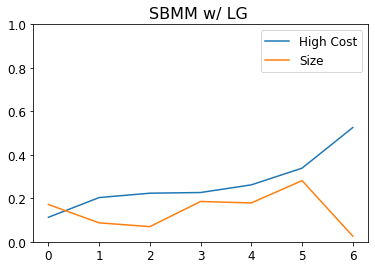

In [13]:
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y=sorted(metTrainSBc['high_cost%']))
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y= metTrainSBc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('SBMM w/ LG ',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)

# Cost Groups: SBMM

In [14]:
Labels = labTrainB

target = pd.DataFrame(ytrain,columns=['Target'])

cadre = pd.DataFrame(Labels,columns=['Cadre'])

target['Cadre']= cadre['Cadre']

highcostratio = np.array([])
clustpop = np.array([])

for i in range(n_clusters):
    pop = target[target['Cadre']==i]['Target'].shape[0]
    clustpop = np.append(clustpop,pop)
    ratio = np.count_nonzero(target[target['Cadre']==i]['Target'].values)*1.0/pop
    highcostratio= np.append(highcostratio,ratio)
    print(pop,ratio)

6531 0.22354922676466085
16045 0.11274540355250857
16717 0.2618890949333014
2434 0.5254724732949877
8151 0.20341062446325603
17343 0.2266620538545811
26322 0.33865207810956616


In [15]:
print('percent of high cost ratio by SBMM')
print(np.sort(highcostratio).round(2))
print('relative cadre size by SBMM')
print((clustpop/clustpop.sum())[np.argsort(highcostratio)].round(3))
print('Log odds ratio for each cadre by SBMM')
print(restest(np.expand_dims(Labels,axis=1),
        np.expand_dims(target['Target'],axis=1))[np.argsort(highcostratio)].round(2))

percent of high cost ratio by SBMM
[0.11 0.2  0.22 0.23 0.26 0.34 0.53]
relative cadre size by SBMM
[0.172 0.087 0.07  0.185 0.179 0.281 0.026]
Log odds ratio for each cadre by SBMM
[-1.11 -0.29 -0.16 -0.16  0.07  0.62  1.24]


# The log odds ratio of being high cost in different clusters

In [16]:
# Order labels
sortedLabels = np.argsort( highcostratio ).tolist()
Labels2 = np.zeros( Labels.shape)-1
index = 0

for sortedNumber in sortedLabels:
    inNumber = np.where( Labels == sortedNumber)[0]
    Labels2[inNumber] = index
    index += 1
Labels = Labels2   

In [17]:
# Calculate log odds ratios for feature vs. cost
from ftest_logodds import ftest_uncorr
target_binary = d_newborn_tr.iloc[:,-1]
data = d_newborn_tr.iloc[:,:-1]
np_feat = np.asarray(features)
labs_binary = np.expand_dims(target_binary,axis=1)

In [18]:
# just show log odds ratio for race and ethnicity features
# 0 lowcost, 1 high cost
feat_table_binary,lor_table_binary =ftest_uncorr(data,labs_binary,np_feat)
pd.DataFrame(lor_table_binary[:,64:72],columns = features[64:72])

,White,Multi_Ethnic,Not_Span_Hispanic,Spanish_Hispanic,Unknown_Ethnicity,ER_No,ER_Yes,Low_BirthWeight
0,0.536927,-0.830452,-0.048132,-0.060539,0.329373,0.696221,-0.697518,-1.946083
1,-0.536927,0.830452,0.048132,0.060539,-0.329373,-0.696221,0.697518,1.946083


In [19]:
# Calculate log odds ratios for feature vs. cluster, uncorr
from ftest_logodds import ftest_uncorr
features = list(d_newborn_tr.iloc[:,:-1])
labs = np.expand_dims(Labels,axis=1)
feat_table,lor_table =ftest_uncorr(data,labs,np_feat)

In [31]:
# reduce feature length
new_feat = [s.replace('CCS_DX_' , '') for s in features]
new_feat = [s.replace('CCS_PROC_' , '') for s in new_feat]
new_feat = [s.replace('not_mental_disorders_or_infectious_disease','')for s in new_feat]
new_feat = [s.replace('birth weight; and','BW&')for s in new_feat]
new_feat = [s.replace('sexually_transmitted_disease','STD')for s in new_feat]
new_feat = [s.replace('tuberculosis','TB')for s in new_feat]
new_feat = [s.replace('system','syst')for s in new_feat]
#new_feat = [s.replace('Other','Ot')for s in new_feat]
#new_feat = [s.replace('OTHER','OT')for s in new_feat]

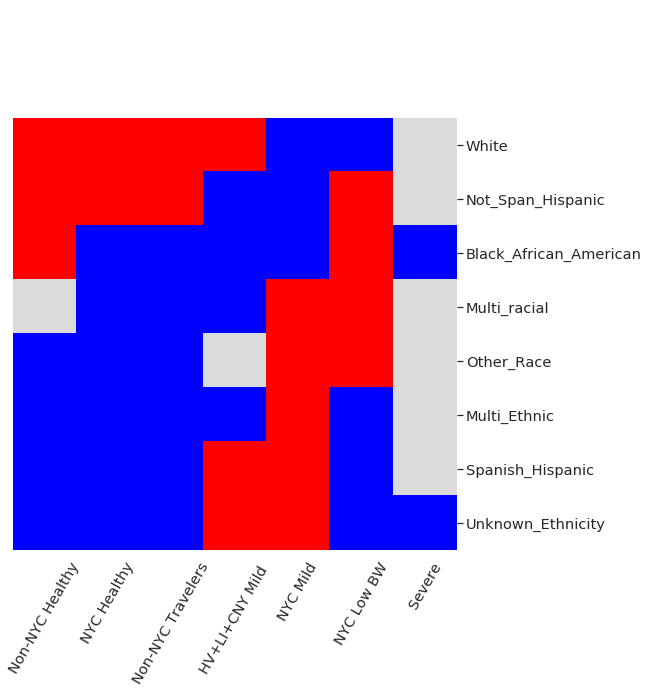

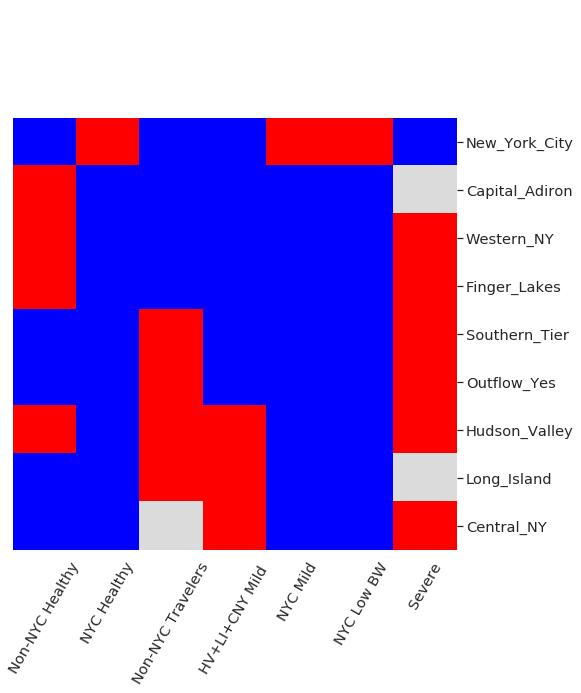

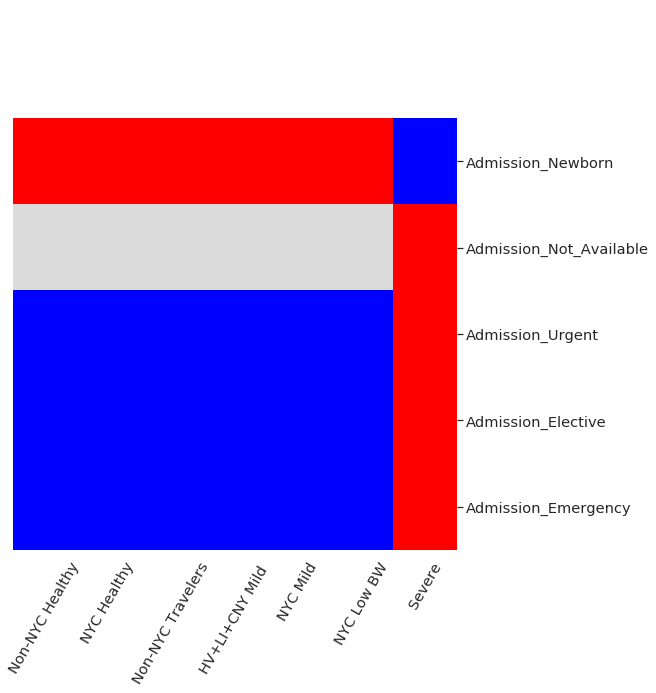

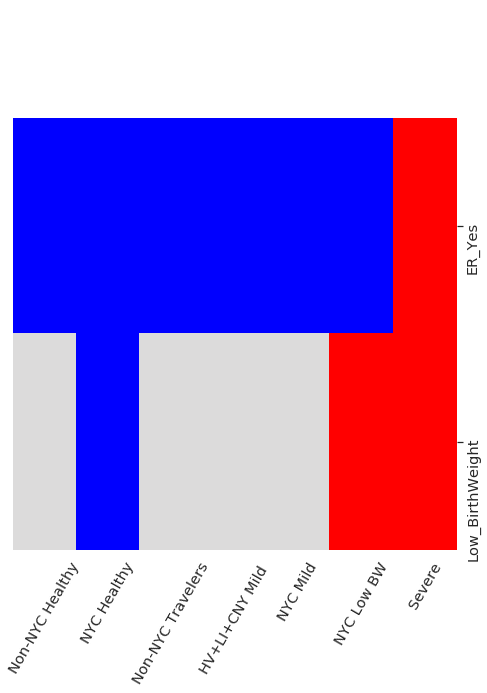

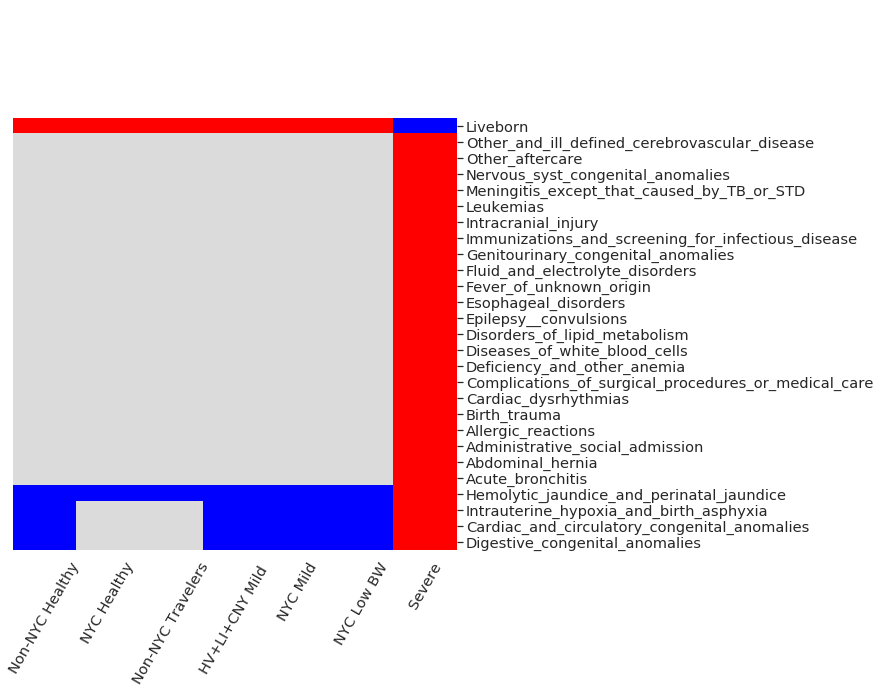

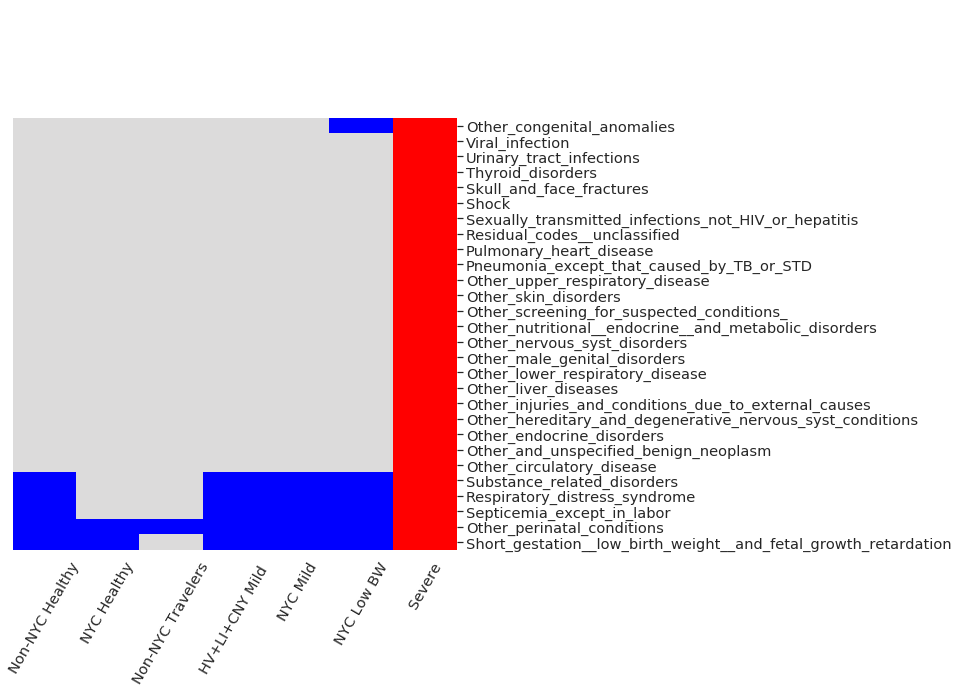

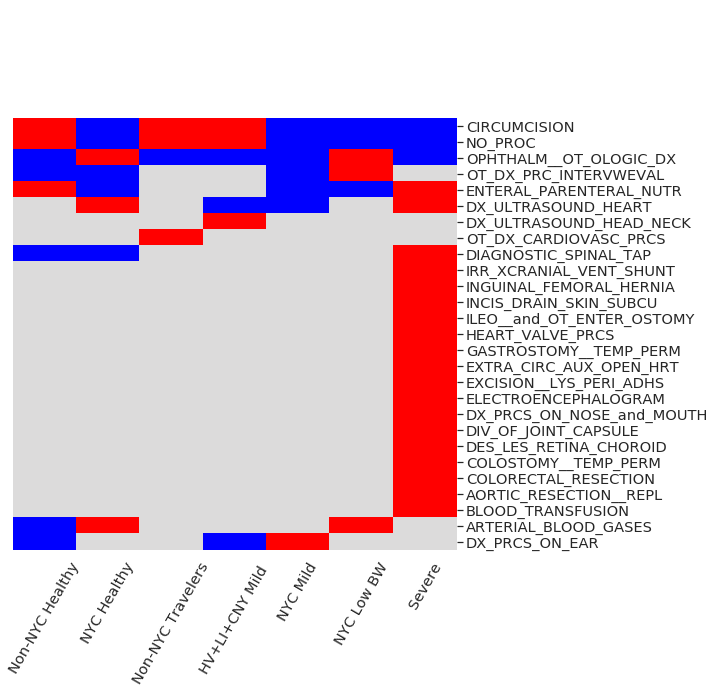

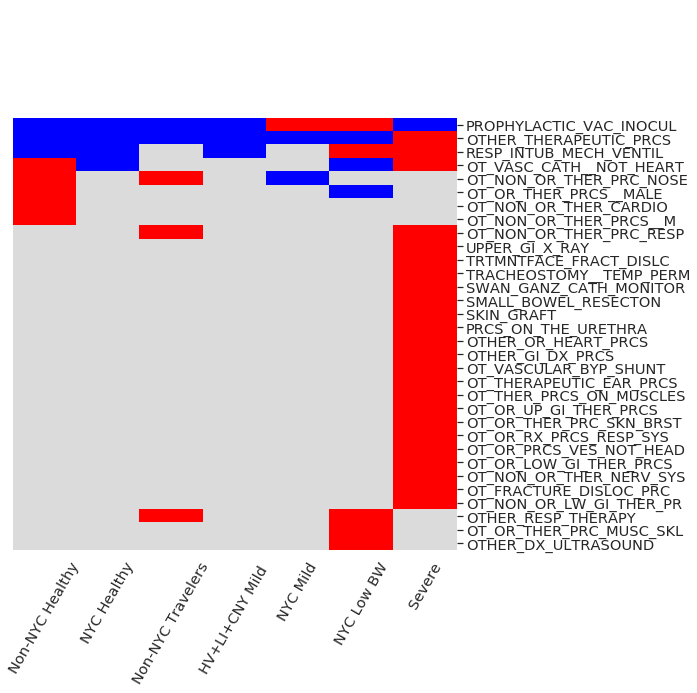

In [66]:
# clustermaps of segments of features.
# Red indicates a given feature has significant positive log ordds ratio to a given cluster, 
# light purple no significance, blue significant negative.

sns.set(font_scale=1.33)
# racial features
race = plotclustmap(feat_table[:,61:69].T, None, np.array(new_feat)[61:69], None, None)

# region features
region = plotclustmap(feat_table[:,np.r_[0:8,74]].T,None, np.array(new_feat)[np.r_[0:8,74]],None,None)

# # # admission features
admission = plotclustmap(feat_table[:,75:80].T,None,np.array(new_feat)[75:80],None,None)

# # ER, Low BW,
birthweight = plotclustmap(feat_table[:,70:72].T,None,np.array(new_feat)[70:72],None,None)

# # #disease features
disease1 = plotclustmap(feat_table[:,80:113][:,np.sum(abs(feat_table[:,80:113]),axis=0)>0].T,
             None,np.array(new_feat)[80:113][np.sum(abs(feat_table[:,80:113]),axis=0)>0],None,None)
disease2 = plotclustmap(feat_table[:,113:142][:,np.sum(abs(feat_table[:,113:142]),axis=0)>0].T,
             None,np.array(new_feat)[113:142][np.sum(abs(feat_table[:,113:142]),axis=0)>0],None,None)

# # # procedure features
procedure1 = plotclustmap(feat_table[:,142:200][:,np.sum(abs(feat_table[:,142:200]),axis=0)>0].T,
             None,np.array(new_feat)[142:200][np.sum(abs(feat_table[:,142:200]),axis=0)>0],None,None)

#plotclustmap(feat_table[:,180:220].T,None,np.array(new_feat)[180:220],None,None)
procedure2 = plotclustmap(feat_table[:,200:][:,np.sum(abs(feat_table[:,200:]),axis=0)>0].T,
             None,np.array(new_feat)[200:][np.sum(abs(feat_table[:,200:]),axis=0)>0],None,None)

# look at the cadre weights

In [24]:
weights = np.array(modelB.weights)[:,1:]
sorted_weights = weights[np.argsort( highcostratio ),:].T 

In [25]:
# bootstraping for coefficients of cadres to be significantly nonzero
nBoot=1000

all_coefs = np.zeros((nBoot, n_clusters, len(features)))

for mm in range(n_clusters):
    data_m = d_newborn_tr[labTrainB==mm] 
    
    for b in range(nBoot):
        d_m_b = data_m.sample(frac=1, random_state=b, replace=True)
        log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=logisRegre[mm].best_params_['C'])
        log_reg.fit(d_m_b[features].values, d_m_b['Target'].values)
        all_coefs[b,mm,:] = np.squeeze(log_reg.coef_)

In [26]:
# estimate a nonzero coefficient with 99% confidence interval
quantiles = np.quantile(all_coefs, (0.005, 0.995), 0)
zero_status = np.zeros((len(features), n_clusters))

for mm in range(n_clusters):
    for p in range(len(features)):
        low_bound, up_bound = quantiles[:,mm,p]
        if low_bound > 0 or up_bound < 0:
            zero_status[p,mm] = 1
zero_status = pd.DataFrame(zero_status, index=features)
zero_status_order = zero_status[np.argsort( highcostratio )]

In [27]:
# make the weights positive, negative, and zero and only consider significant weights from bootstrapping
qualitative_weights = (sorted_weights < 0)*(-1) + (sorted_weights > 0)*1
filtered_weights = qualitative_weights*zero_status_order.values

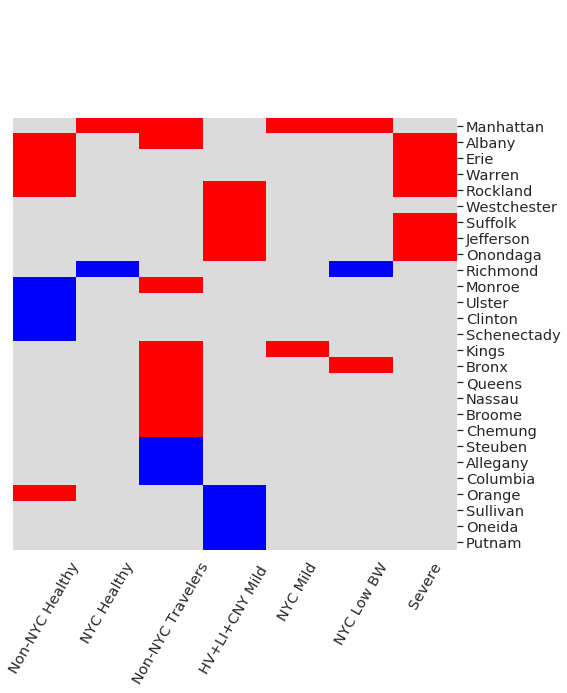

In [67]:
# county weights 
county_weights = filtered_weights[8:58,:]
# plot the clustermap of filtered  county weights 
county_w = plotclustmap((county_weights ) [np.sum(abs(county_weights),axis=1)>0,:], None, np.array(new_feat[8:58])[np.sum(abs(county_weights),axis=1)>0], None, None)

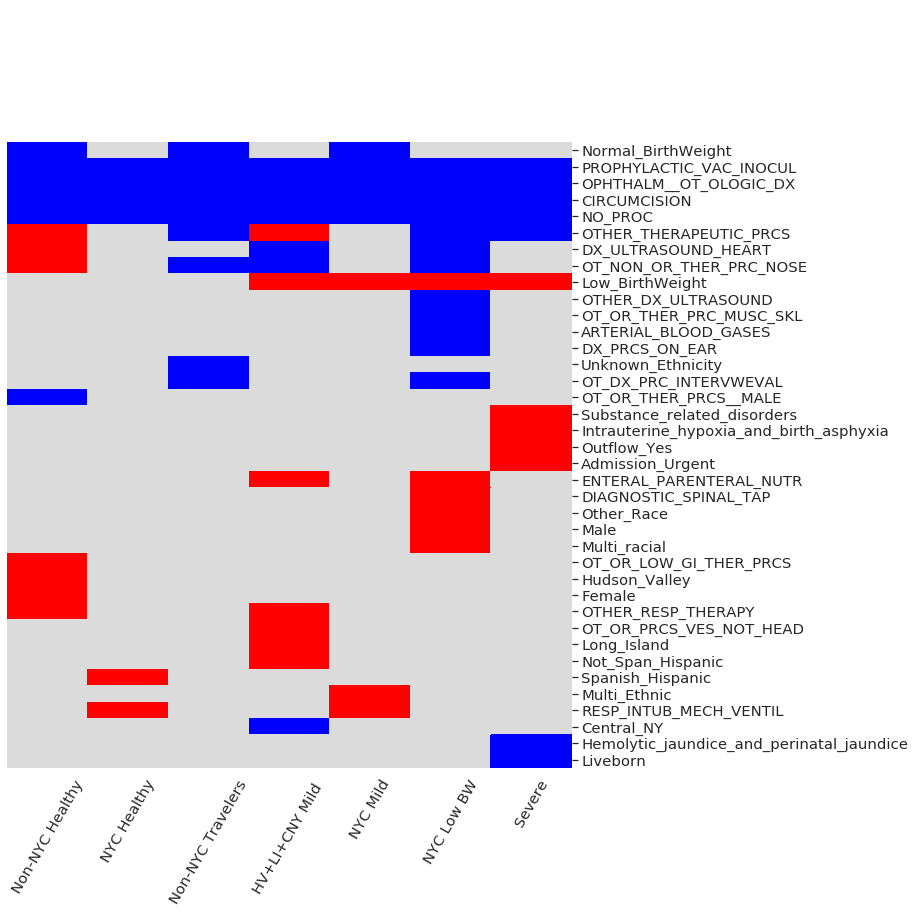

In [81]:
sns.set(font_scale=1.35)
# noncounty weights 
noncounty_weights = filtered_weights[np.r_[0:8,58:259],:]
# plot the clustermap of filtered  noncounty weights 
general_w = plotclustmap((noncounty_weights ) [np.sum(abs(noncounty_weights),axis=1)>0,:], None, np.array(new_feat)[np.r_[0:8,58:259]][np.sum(abs(noncounty_weights),axis=1)>0], None, None)

In [69]:
race.savefig('race.png',dpi = 1000)
region.savefig('region.png',dpi = 1000)
admission.savefig('admission.png',dpi = 1000)
birthweight.savefig('birthweight.png',dpi = 1000)
disease1.savefig('disease1.png',dpi = 1000)
disease2.savefig('disease2.png',dpi = 1000)
procedure1.savefig('procedure1.png',dpi = 1000)
procedure2.savefig('procedure2.png',dpi = 1000)
county_w.savefig('county_weights.png',dpi = 1000)
general_w.savefig('general_weights.png',dpi = 1000)

In [82]:
general_w.savefig('general_weights.png',dpi = 1000)